In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


no gdal


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from typing import Tuple
import pandas as pd

In [3]:
def generate(n_interfaces: int, seed=42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    surface_points = pd.DataFrame()
    orientations = pd.DataFrame()
    
    for n in range(n_interfaces):
        x = np.random.rand(15) * 3
        y = np.random.rand(15)
        
        def func(x, y):
            return np.sin(x) + np.cos(y)
        
        z = func(x, y) + n
        
        surfpts = pd.DataFrame({"X": x, "Y": y, "Z": z})
        surfpts["formation"] = "Interface {}".format(n + 1)
        surface_points = surface_points.append(surfpts)
        
        orientpts = pd.DataFrame({"X": [np.mean(surfpts.X)], "Y": [np.mean(surfpts.Y)], "Z": [np.mean(surfpts.Z)], "azimuth": [90], "dip": [3], "polarity": [1], "formation": ["Interface {}".format(n + 1)]})
        orientations = orientations.append(orientpts)
    return surface_points, orientations
    
surface_points, orientations = generate(3, seed=41)

In [4]:
surface_points.to_csv("surfpts.csv", index=False)
orientations.to_csv("orientpts.csv", index=False)

In [5]:
geo_model = gp.create_model('StochSurfTesting')
gp.init_data(geo_model, [surface_points.min().X * 0.95, surface_points.max().X * 1.05,
                         surface_points.min().Y * 0.95, surface_points.max().Y * 1.05,
                         surface_points.min().Z * 0.2, surface_points.max().Z * 1.2],
             [50,50,50], path_i="surfpts.csv", path_o="orientpts.csv")

StochSurfTesting  2019-04-29 12:49

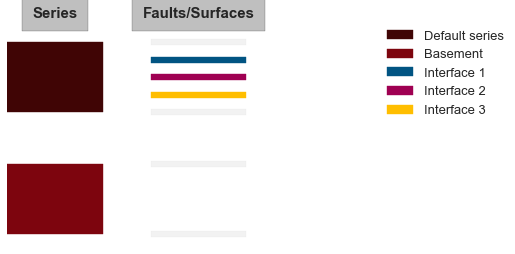

In [6]:
gp.map_series_to_surfaces(geo_model, 
                            {"Default series": ["Interface {}".format(n + 1) for n in range(3)]})

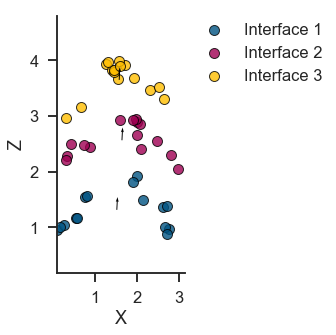

In [16]:
gp.plot.plot_data(geo_model)

In [8]:
gp.set_interpolation_data(
    geo_model, output='geology', compile_theano=True, theano_optimizer='fast_compile'
)

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


In [9]:
sol = gp.compute_model(geo_model, compute_mesh=True)

In [10]:
gp.plot.plot_surfaces_3d_ipv(geo_model)

In [11]:
from stochasticsurf import StochasticSurfaceScipy

In [20]:
surfaces = ["Interface {}".format(n + 1) for n in range(3)]
surfaces

['Interface 1', 'Interface 2', 'Interface 3']

In [12]:
stochastic_surfaces = []
for surface in surfaces:
    stochsurf = StochasticSurfaceScipy(geo_model, surface)  # create stochastic surf obj
    stochastic_surfaces.append(stochsurf)  

In [21]:
for stochsurf in stochastic_surfaces:
    stochsurf.parametrize_surfpts_naive(factor=0.005, direction="X")

In [22]:
for stochsurf in stochastic_surfaces:
    stochsurf.modify_surface_points()
#     stochsurf

In [23]:
sol = gp.compute_model(geo_model, compute_mesh=True)
gp.plot.plot_surfaces_3d_ipv(geo_model)

In [18]:
geo_model.solutions.block_matrix.shape

(1, 1, 125000)

In [31]:
import scipy.stats as ss

In [47]:
stoch_param = {"Z": [
            ss.norm(loc=0, scale=stochsurf.geo_model.grid.extent[5] * 0.01)
            for z in stochsurf.surface_points.loc[stochsurf.isurf].Z
        ],
              "Y": [
            ss.norm(loc=0, scale=stochsurf.geo_model.grid.extent[5] * 0.01)
            for z in stochsurf.surface_points.loc[stochsurf.isurf].Z
        ]}

In [49]:
for key, value in stoch_param.items():
    print(key, value)

Z [<scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AB60B70>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400B7720B8>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AB74B38>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AB74160>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AB74470>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AB748D0>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AB74E48>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400B595B00>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AAE83C8>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AAE8208>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400AB10240>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400B3B2550>, <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002400B3B2AC8>, <scipy.st

In [51]:
for key, value in {"X": [1, 2, 3], "Y": [3, 2, 1]}.items():
    print(key, value)

X [1, 2, 3]
Y [3, 2, 1]


In [42]:
geo_model.surface_points.df.loc[1:2, "X"].values

array([2.09235348, 0.26095278])

In [154]:
pd.DataFrame(ver).to_csv("ver.csv", index=False)

In [155]:
pd.DataFrame(sim).to_csv("sim.csv", index=False)

In [81]:
solutions = []
vertices = []
simplices = []

for _ in range(10):
    zmod = stochastic_surface.draw_surfpts()  # draw z modifier
    surfptsmod = geo_model.modify_surface_points(stochastic_surface.isurf, **{"Z": surfpts.Z.values + zmod})  # apply
    sol = gp.compute_model(geo_model, compute_mesh=True)
    solutions.append(sol)
    # store results
    vertices.append(sol.vertices[0].astype("float32"))
    simplices.append(sol.edges[0])

In [44]:
import vtki
vtki.__version__

'0.18.4'

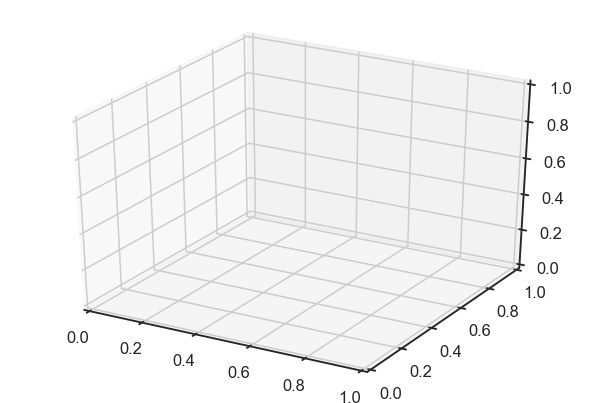

In [147]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)


In [148]:
ver

array([[0.0000000e+00, 1.9715871e-03, 1.0200000e+00],
       [0.0000000e+00, 2.0000000e-02, 1.0118009e+00],
       [4.6805479e-03, 2.0000000e-02, 1.0200000e+00],
       ...,
       [2.9400001e+00, 9.5378411e-01, 7.2000003e-01],
       [2.9123356e+00, 9.8000002e-01, 7.2000003e-01],
       [2.9400001e+00, 9.8000002e-01, 6.9890046e-01]], dtype=float32)

In [63]:
import ipywidgets as ipyw

In [106]:
def plot(i):
    ver = vertices[i]
    sim = simplices[i]
    fig = ipv.gcf()
    mesh = ipv.plot_trisurf(
        ver[:, 0],
        ver[:, 1],
        ver[:, 2],
        triangles=sim,
    )

In [ ]:

gp.plot.plot_surfaces_3d_ipv(geo_model)

In [ ]:
ipv.figure()

mesh = ipv.plot_trisurf(
    ver[:, 0],
    ver[:, 1],
    ver[:, 2],
    triangles=sim,
    color=list(self.geo_model.surfaces.df['color'])[surf]
)

ipv.xlim(self.geo_model.grid.extent[0], self.geo_model.grid.extent[1])
ipv.ylim(self.geo_model.grid.extent[2], self.geo_model.grid.extent[3])
ipv.zlim(self.geo_model.grid.extent[4], self.geo_model.grid.extent[5])
ipv.show()
return ipv